In [9]:
from vivarium import Artifact
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from db_queries import get_ids, get_outputs
import scipy.stats

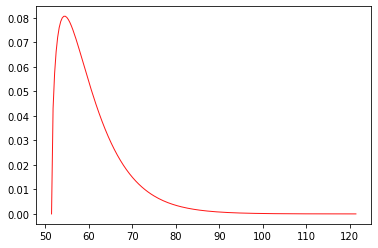

In [10]:
# distribution for the cost of BEP
loc = 51.42
mean = 60.42 - loc
a = 1.5
scale = mean/a
fig, ax = plt.subplots(1,1)
x = np.linspace(loc, loc+(120-50), 200)
ax.plot(x, scipy.stats.gamma.pdf(x, a, loc, scale), 'r-', lw=1, alpha=0.9, label='beta pdf')
plt.show()

In [11]:
output_dirs = ['/ihme/costeffectiveness/results/vivarium_gates_bep/lbwsg_acmr/india/2020_02_24_01_05_37/count_data/',
               '/ihme/costeffectiveness/results/vivarium_gates_bep/lbwsg_acmr/mali/2020_02_24_01_07_25/count_data/',
               '/ihme/costeffectiveness/results/vivarium_gates_bep/lbwsg_acmr/pakistan/2020_02_24_01_08_41/count_data/',
               '/ihme/costeffectiveness/results/vivarium_gates_bep/lbwsg_acmr/tanzania/2020_02_24_01_10_34/count_data/']

locations = ['India','Mali','Pakistan','Tanzania']

In [18]:
#DALYs

master_avg = pd.DataFrame()
master_draws = pd.DataFrame()
master_counts = pd.DataFrame()

for i in list(range(0,4)):
    ylls = pd.read_hdf(output_dirs[i] + 'ylls.hdf').reset_index().groupby(['input_draw','scenario']).sum().reset_index().drop(columns='index').rename(columns={'value':'ylls'})
    ylds = pd.read_hdf(output_dirs[i] + 'ylds.hdf').reset_index().groupby(['input_draw','scenario']).sum().reset_index().drop(columns='index').rename(columns={'value':'ylds'})
    dalys = ylls.merge(ylds, right_on=['input_draw','scenario'], left_on=['input_draw','scenario'])
    dalys['dalys'] = dalys['ylls'] + dalys['ylds']
    dalys = dalys.drop(columns=['ylls','ylds'])
    person_time = pd.read_hdf(output_dirs[i] + 'person_time.hdf').reset_index().groupby(['input_draw','scenario']).sum().reset_index().drop(columns='index').rename(columns={'value':'person_time'})
    treatment = pd.read_hdf(output_dirs[i] + 'population.hdf').reset_index().groupby(['input_draw','scenario','treatment_group','measure']).sum().reset_index().drop(columns='index').rename(columns={'value':'population'})
    treatment = treatment.where(treatment['measure'] == 'total_population').dropna()
    treatment = pd.pivot_table(treatment, index=['input_draw','scenario'], columns='treatment_group', values='population').reset_index()
    treatment = treatment.rename(columns={'all':'total_population',
                               'bep':'bep_population',
                               'ifa':'ifa_population',
                               'mmn':'mmn_population',
                               'none':'untreated_population'})
    
    dalys_pt = dalys.merge(person_time, right_on=['input_draw','scenario'], 
                          left_on=['input_draw','scenario'])
    dalys_tot = dalys_pt.merge(treatment, right_on=['input_draw','scenario'], 
                          left_on=['input_draw','scenario'])
    count = dalys_tot
    count['location'] = locations[i]
    master_counts = master_counts.append(count)

    # add cost data
    dalys_baseline = pd.DataFrame.copy(dalys_tot.where(dalys_tot['scenario'] == 'baseline').dropna().drop(columns='scenario'))
    dalys_baseline['cost'] = 2.69 * dalys_baseline['ifa_population'] 
    
    
    dalys_mmn = pd.DataFrame.copy(dalys_tot.where(dalys_tot['scenario'] == 'mmn_scale_up').dropna().drop(columns='scenario'))
    dalys_mmn['cost'] = 3.69 * dalys_mmn['mmn_population'] 
  

    dalys_bep = pd.DataFrame.copy(dalys_tot.where(dalys_tot['scenario'] == 'bep_scale_up').dropna().drop(columns='scenario'))
    np.random.seed(12345)
    dalys_bep['cost'] = dalys_bep['bep_population'] * scipy.stats.gamma.rvs(a, loc, scale, size=len(dalys_bep['person_time'])) 
    dalys_bep['cost_bep_avg'] = 60.42 * dalys_bep['bep_population'] 
    dalys_bep['cost_bep_low'] = 51.42 * dalys_bep['bep_population'] 
    dalys_bep['cost_bep_high'] = 120.42 * dalys_bep['bep_population'] 
    dalys_bep = dalys_bep.drop(columns='person_time')
    
    dalys_bep_targeted = pd.DataFrame.copy(dalys_tot.where(dalys_tot['scenario'] == 'bep_targeted_scale_up').dropna().drop(columns='scenario'))
    np.random.seed(12345)
    dalys_bep_targeted['cost'] = (dalys_bep_targeted['bep_population'] * scipy.stats.gamma.rvs(a, loc, scale, size=len(dalys_bep_targeted['person_time']))+ dalys_bep_targeted['mmn_population'] * 3.69)
    dalys_bep_targeted['cost_bep_targeted_avg'] = (60.42 * dalys_bep_targeted['bep_population'] + dalys_bep_targeted['mmn_population'] * 3.69) 
    dalys_bep_targeted['cost_bep_targeted_low'] = (51.42 * dalys_bep_targeted['bep_population'] + dalys_bep_targeted['mmn_population'] * 3.69) 
    dalys_bep_targeted['cost_bep_targeted_high'] = (120.42 * dalys_bep_targeted['bep_population'] + dalys_bep_targeted['mmn_population'] * 3.69) 
    dalys_bep_targeted = dalys_bep_targeted.drop(columns='person_time')
    
    
    dalys_scenarios1 = dalys_baseline.merge(dalys_mmn, right_on=['input_draw'],
                             left_on=['input_draw'], suffixes=['_baseline','_mmn'])
    dalys_scenarios2 = dalys_baseline.merge(dalys_bep, right_on=['input_draw'],
                             left_on=['input_draw'], suffixes=['_baseline','_bep'])
    dalys_scenarios3 = dalys_baseline.merge(dalys_bep_targeted, right_on=['input_draw'],
                             left_on=['input_draw'], suffixes=['_baseline','_bep_targeted'])
    dalys_scenarios4 = dalys_scenarios1.merge(dalys_scenarios2, right_on=['input_draw'],
                             left_on=['input_draw'], suffixes=['','_drop'])
    dalys_scenarios = dalys_scenarios4.merge(dalys_scenarios3, right_on=['input_draw'],
                             left_on=['input_draw'], suffixes=['','_drop'])
    dalys_scenarios = dalys_scenarios.drop(columns=[c for c in dalys_scenarios.columns if 'drop' in c])

  #ICERS
    #mmn vs baseline
    dalys_scenarios['cost_averted_mmn'] = dalys_scenarios['cost_mmn'] - dalys_scenarios['cost_baseline']
    dalys_scenarios['dalys_averted_mmn'] = dalys_scenarios['dalys_baseline'] - dalys_scenarios['dalys_mmn']
    dalys_scenarios['icer_mmn_rel_to_baseline'] = dalys_scenarios['cost_averted_mmn'] / dalys_scenarios['dalys_averted_mmn']
        
    #bep universal vs baseline
    dalys_scenarios['cost_averted_bep_universal'] = dalys_scenarios['cost_bep'] - dalys_scenarios['cost_baseline']
    dalys_scenarios['dalys_averted_bep_universal'] = dalys_scenarios['dalys_baseline'] - dalys_scenarios['dalys_bep']
    dalys_scenarios['icer_bep_universal_rel_to_baseline'] = dalys_scenarios['cost_averted_bep_universal'] / dalys_scenarios['dalys_averted_bep_universal']
        
    #bep targeted vs baseline
    dalys_scenarios['dalys_averted_bep_targeted'] = dalys_scenarios['dalys_baseline'] - dalys_scenarios['dalys_bep_targeted']
    dalys_scenarios['cost_averted_bep_targeted'] = dalys_scenarios['cost_bep_targeted'] - dalys_scenarios['cost_baseline']
    dalys_scenarios['icer_bep_targeted_rel_to_baseline'] = dalys_scenarios['cost_averted_bep_targeted'] / dalys_scenarios['dalys_averted_bep_targeted']
            
    #bep universal vs. mmn
    dalys_scenarios['cost_averted_bep_rel_to_mmn'] = dalys_scenarios['cost_bep'] - dalys_scenarios['cost_mmn']
    dalys_scenarios['dalys_averted_bep_rel_to_mmn'] = dalys_scenarios['dalys_mmn'] - dalys_scenarios['dalys_bep']
    dalys_scenarios['icer_bep_universal_rel_to_mmn'] = dalys_scenarios['cost_averted_bep_rel_to_mmn'] / dalys_scenarios['dalys_averted_bep_rel_to_mmn']

    #bep targeted vs mmn
    dalys_scenarios['cost_averted_bep_targeted_rel_to_mmn'] = dalys_scenarios['cost_bep_targeted'] - dalys_scenarios['cost_mmn']
    dalys_scenarios['dalys_averted_bep_targeted_rel_to_mmn'] = dalys_scenarios['dalys_mmn'] - dalys_scenarios['dalys_bep_targeted']
    dalys_scenarios['icer_bep_targeted_rel_to_mmn'] = dalys_scenarios['cost_averted_bep_targeted_rel_to_mmn'] / dalys_scenarios['dalys_averted_bep_targeted_rel_to_mmn']
    
    dalys_scenarios = dalys_scenarios.set_index(['input_draw'])
    
    dalys_scenarios['location'] = locations[i]
    master_draws = master_draws.append(dalys_scenarios.reset_index())
        
    dalys_prep = dalys_scenarios.reset_index().drop(columns=['input_draw','person_time'])
    dalys_mean = pd.DataFrame(dalys_prep.mean())
    dalys_min = pd.DataFrame(dalys_prep.quantile(0.025))
    dalys_max = pd.DataFrame(dalys_prep.quantile(0.975))
    
    per_pt1 = dalys_mean.merge(dalys_min, right_index=True, left_index=True)
    #per_pt2 = dalys_mean.merge(dalys_max, right_index=True, left_index=True)
    final_per_pt = per_pt1.merge(dalys_max, right_index=True, left_index=True)#, suffixes=['','_drop'])
    final_per_pt = final_per_pt.rename(columns={0.0:'mean', 0.025:'min', 0.975:'max'})#.drop(columns='0.0_mean_drop')
    final_per_pt = final_per_pt.reset_index()
    final_per_pt['location'] = locations[i]
    master_avg = master_avg.append(final_per_pt)

master_avg.head()

,index,mean,min,max,location
0,dalys_baseline,287190.863021,267584.177356,303195.622101,India
1,person_time_baseline,194163.569555,193863.715058,194542.150376,India
2,total_population_baseline,100000.000000,100000.000000,100000.000000,India
3,bep_population_baseline,0.000000,0.000000,0.000000,India
4,ifa_population_baseline,34031.680000,31674.800000,38239.625000,India


In [24]:
#DALY

master_avg.where(master_avg['index'].str.contains('dalys_averted')).where(master_avg['location'] == 'Tanzania').dropna()

,index,mean,min,max,location
37,dalys_averted_mmn,1724.307037,898.454229,2929.259698,Tanzania
40,dalys_averted_bep_universal,24143.478744,17642.678647,32303.310182,Tanzania
42,dalys_averted_bep_targeted,6509.374310,4289.742565,9664.002911,Tanzania
46,dalys_averted_bep_rel_to_mmn,22419.171707,16417.627733,30106.688409,Tanzania
49,dalys_averted_bep_targeted_rel_to_mmn,4785.067273,2953.202119,7208.981195,Tanzania


In [36]:
#POPULATION

master_avg.where(master_avg['index'].str.contains('population')).where(master_avg['location'] == 'Tanzania').dropna()

,index,mean,min,max,location
2,total_population_baseline,100000.00,100000.000,100000.000,Tanzania
3,bep_population_baseline,0.00,0.000,0.000,Tanzania
4,ifa_population_baseline,20970.90,19424.500,23695.400,Tanzania
5,mmn_population_baseline,0.00,0.000,0.000,Tanzania
6,untreated_population_baseline,79029.10,76304.600,80575.500,Tanzania
10,total_population_mmn,100000.00,100000.000,100000.000,Tanzania
11,bep_population_mmn,0.00,0.000,0.000,Tanzania
12,ifa_population_mmn,0.00,0.000,0.000,Tanzania
13,mmn_population_mmn,88484.88,88090.525,88824.825,Tanzania
14,untreated_population_mmn,11515.12,11175.175,11909.475,Tanzania


In [38]:
#COST

master_avg.where(master_avg['index'].str.contains('cost')).where(master_avg['location'] == 'Tanzania').dropna()

,index,mean,min,max,location
7,cost_baseline,5.641172e+04,5.225190e+04,6.374063e+04,Tanzania
15,cost_mmn,3.265092e+05,3.250540e+05,3.277636e+05,Tanzania
22,cost_bep,5.444176e+06,4.646209e+06,7.313670e+06,Tanzania
23,cost_bep_avg,5.346256e+06,5.322430e+06,5.366796e+06,Tanzania
24,cost_bep_low,4.549893e+06,4.529615e+06,4.567373e+06,Tanzania
25,cost_bep_high,1.065535e+07,1.060786e+07,1.069629e+07,Tanzania
32,cost_bep_targeted,8.165985e+05,7.193546e+05,9.945873e+05,Tanzania
33,cost_bep_targeted_avg,8.068285e+05,7.654998e+05,8.527703e+05,Tanzania
34,cost_bep_targeted_low,7.306277e+05,6.959118e+05,7.692426e+05,Tanzania
35,cost_bep_targeted_high,1.314834e+06,1.229420e+06,1.409621e+06,Tanzania


In [26]:
#ICER
master_avg.where(master_avg['index'].str.contains('icer')).where(master_avg['location'] == 'Tanzania').dropna()

,index,mean,min,max,location
38,icer_mmn_rel_to_baseline,174.898270,91.761781,304.876767,Tanzania
41,icer_bep_universal_rel_to_baseline,228.766619,164.490925,332.287986,Tanzania
44,icer_bep_targeted_rel_to_baseline,121.892844,79.323649,171.710228,Tanzania
47,icer_bep_universal_rel_to_mmn,234.673347,164.660877,349.813505,Tanzania
50,icer_bep_targeted_rel_to_mmn,108.038888,70.739539,166.940762,Tanzania
